In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
from yaml import dump
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
# import timm

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

# import gpumap
from c3linearize import linearize, class_graph

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn import data as datautils
from omnilearn.data import InterventionSamplerBase, ISupervisedDataset

from sklearn.decomposition import PCA
import sklearn.datasets


# from src import sample_full_interventions, response_mat, factor_reponses
# from src.responses import sample_full_interventions

fig.initialize('sae')
from omnifig.projects import sae
import networkx as nx

# from src import sample_full_interventions, response_mat, factor_reponses
dataset = None
src = None
def viz(config): # Utility function to print out config objects nicely
    print(dump(config.pythonize()), end='')

2021-09-30 11:07:56.638398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /is/ei/fleeb/.mujoco/mujoco200/bin
2021-09-30 11:07:56.638413: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
device = 'cuda'
figure_dir = Path('../learn_rep/figures/extrapolation')
figure_dir = Path(r'C:\Users\anwan\OneDrive\Khan\research\learn_rep\figures\neurips')
figure_dir = None
figure_root = None
seed = 10
torch.manual_seed(seed)

src = None

num_nodes = 5

B = 48
D = 8
M = 1
G = 32
C = 3
H, W = 100, 100
# H, W = 64, 64

In [3]:
# dscode = 'd/celeba'

# dataset  = fig.quick_run('load-data', 'd/celeba', cat='complex', supervised=True, shuffle=False, seed=seed,)
# dataset  = fig.quick_run('load-data', 'd/celeba', supervised=True, shuffle=False, seed=seed,)
# dataset  = fig.quick_run('load-data', 'd/mnist', supervised=True, shuffle=False, seed=seed,)
# dataset  = fig.quick_run('load-data', 'd/3ds', supervised=True, shuffle=False, seed=seed,)

# dataset = fig.quick_run('load-data', name='cifar10', download=True, supervised=True, shuffle=False, seed=seed,)

dataset  = fig.quick_run('load-data', 'd/celeba', supervised=True, shuffle=False, seed=seed, model=None,
                       **{'dataset':{'_dataset_mod.encoded': 1}, 
                          'progress-bar':{'_type':'progress-bar', 'display-on':'jupyter'}})

# dataset  = fig.quick_run('load-data', 'd/mpi', model=None, cat='toy', labeled=True, shuffle=False, seed=seed,
#                        **{'dataset':{'_dataset_mod.encoded': 1}, 
#                           'progress-bar':{'_type':'progress-bar', 'display-on':'jupyter'}})

# dataset  = fig.quick_run('load-data', dscode, model=None, label_type='attr', shuffle=False, seed=seed,
#                        **{'dataset':{'_dataset_mod.encoded': 1}, 
#                           'progress-bar':{'_type':'progress-bar', 'display-on':'jupyter'}})

# dataset  = fig.quick_run('load-data', name='3dshapes', labeled=True, shuffle=False, seed=seed,
#                        **{'dataset._dataset_mod.encoded': 1, 'progress-bar':{'_type':'progress-bar', 'display-on':'jupyter'}})
# dataset = fig.quick_run('load-data', name='3dshapes', labeled=True, shuffle=False, seed=seed,
#                        **{'_dataset_mod.encoded': 1, 'progress-bar':{'_type':'progress-bar', 'display-on':'jupyter'}})
# dataset = fig.quick_run('load-data', name='mnist', labeled=True, shuffle=False, seed=seed, **{'_dataset_mod.encoded': 1, 'progress-bar':{'_type':'progress-bar', 'display-on':'jupyter'}})

# dataset = fig.quick_run('load-data', 'd/3ds', labeled=True, seed=seed)
len(dataset)

| dataset: [<class 'omnifig.config.ConfigDict'>]
| CREATING . (type=dataset)
|  > .num_workers: 0
|  > batch_size: 32
|  > shuffle: True
|  > drop_last: True
|  > .step_device --> .device: 'cuda'
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > split [dict with 1 item/s]
|  >  > (val): 0.1
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > wrappers: [] (by default)
|  > default-mode --> mode: 'train' (by default)
|  > _dataset_type --> dataset-name --> name: 'celeba'
|  > _dataset_mod [dict with 1 item/s]
|  >  > (encoded): 1
|  > mode-aliases [dict with 1 item/s]
|  >  > (eval): 'val'
|  > .seed: 10
|  > device: 'cpu'
|  > pin_memory: False (by default)
|  > epoch_seed --> .seed: 10
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/celeba) (mod={'encoded': 1})
|  >  > encoder --> .model: None
|  >  > sample-best: True (by default)
|  >  > batch-size: 64 (by default)
|  >  > CREATI

146493

In [4]:
dataset.register_wrapper('subset', kwargs={'num': 100, 'update_data':False})

In [5]:
len(dataset)

100

In [6]:
# obs = dataset.get('observations')
# util.plot_imgs(obs,figsize=(9,9));
# obs.shape

In [7]:
imgshape = dataset.din
imgshape, dataset.dout

((3, 128, 128), (3, 128, 128))

In [8]:
# model = fig.quick_run('load-model', load='mnist_ae_e-conv_d-s6_210818-091603')
# model = fig.quick_run('load-model', load='mnist_vae1_e-conv_d-conv_210910-135535')
# model = fig.quick_run('load-model', load='mnist_ae_e-conv_d-conv_210912-141407')
# model = fig.quick_run('load-model', load='3ds_vae2_d-conv_s3_210626-030352')
# model = fig.quick_run('load-model', 'hybrid', 'm/ae', 'a/conv12', 'd/3ds', din=imgshape, dout=imgshape)
model = fig.quick_run('load-model', 'hybrid', 'm/ae', 'a/conv16', 'd/celeba', din=imgshape, dout=imgshape)
model

| _load-ckpt --> load-model --> load: None (by default)
| model._model_mod [dict with 1 item/s]
|  > (hybrid): 1
| .seed: 0
| CREATING model (type=ae) (mod={'hybrid': 1})
|  > viz-gen-hybrid: True (by default)
|  > skip-expensive: False (by default)
|  > CREATING encoder (type=multilayer)
|  >  > _din --> ..din: (3, 128, 128)
|  >  > _dout --> ..latent-dim: 32
|  >  > in_order: True (by default)
|  >  > first: [<class 'omnifig.config.ConfigDict'>]
|  >  > CREATING . (type=conv-layer)
|  >  >  > in-shape --> din: (3, 128, 128)
|  >  >  > ..channels: 128
|  >  >  > out-shape --> dout: None
|  >  >  > transpose: None (by default)
|  >  >  > down: 2
|  >  >  > up: None (by default)
|  >  >  > .pool: 'max'
|  >  >  > kernel_size --> kernel: 5
|  >  >  > padding: 2 (by default)
|  >  >  > dilation: (1, 1) (by default)
|  >  >  > stride: (1, 1) (by default)
|  >  >  > ..norm: 'group'
|  >  >  > ..nonlin: 'elu'
|  >  >  > conv_kwargs: {} (by default)
|  >  >  > residual: False (by default)
|  

| _print_model: False (by default)


Hybrid_Autoencoder(
  (encoder): MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride

In [9]:
dataset.set_encoder(model)

  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
dataset.din, dataset.dout

(32, (3, 128, 128))

In [11]:
dataset.get_mechanism_space()

Joint(Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary())

In [12]:
dataset.get_label_space()

Joint(Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary(), Binary())

In [13]:
builder = fig.quick_create('estimator-builder')
builder

| use-mechanisms: False (by default)
| [Pushed] default-regressor: 'gbt-regressor'
| [Pushed] default-classifier: 'gbt-classifier'
| _source: None (by default)


In [14]:
est = builder.build(dataset.get_label_space())
est

| CREATING joint (type=joint-estimator)
|  > estimators: [] (by default)
|  > stats: None (by default)
|  > stats-fmt: None (by default)
|  > smooth-tau --> tau: None (by default)
|  > mode: 'train' (by default)
|  > din: None (by default)
|  > dout: None (by default)
|  > device: 'cuda' (by default)
| CREATING .categorical (type=gbt-classifier)
|  > gb_loss --> loss: 'deviance' (by default)
|  > gb_learning_rate --> learning_rate: 0.1 (by default)
|  > n_estimators: 100 (by default)
|  > subsample: 1.0 (by default)
|  > gb_criterion: 'friedman_mse' (by default)
|  > min_samples_split: 2 (by default)
|  > min_samples_leaf: 1 (by default)
|  > min_weight_fraction_leaf: 0.0 (by default)
|  > max_depth: 3 (by default)
|  > max_impurity_decrease: 0.0 (by default)
|  > min_impurity_split: None (by default)
|  > init: None (by default)
|  > random_state: None (by default)
|  > max_features: None (by default)
|  > verbose: False (by default)
|  > max_leaf_nodes: None (by default)
|  > warm_st

JointEstimator()

In [15]:
# est.estimators

In [16]:
dataset.observations.shape

torch.Size([100, 32])

In [17]:
dataset.get('observations').shape

torch.Size([100, 32])

In [18]:
dataset._active.targets

In [19]:
dataset.get('targets').shape

torch.Size([100, 40])

In [20]:
out = est._process_inputs('_fit', dataset)
len(out)

| .num_workers: 0
| batch_size: 32
| shuffle: True
| drop_last: True
| .step_device --> .device: 'cuda'
| infinite: False (by default)
| extractor: None (by default)
| allow_batched: True (by default)
| split [dict with 1 item/s]
|  > (val): 0.1
| shuffle-split: True (by default)
| split-src: 'train' (by default)
| wrappers: [] (by default)
| default-mode --> mode: 'train'
| _dataset_type --> dataset-name --> name: 'celeba'
| _dataset_mod [dict with 1 item/s]
|  > (encoded): 1
| mode-aliases [dict with 1 item/s]
|  > (eval): 'val'
| .seed: 10
| device: 'cpu'
| pin_memory: False (by default)
| epoch_seed --> .seed: 10
| .num_workers: 0
| batch_size: 32
| shuffle: True
| drop_last: True
| .step_device --> .device: 'cuda'
| infinite: False (by default)
| extractor: None (by default)
| allow_batched: True (by default)
| split [dict with 1 item/s]
|  > (val): 0.1
| shuffle-split: True (by default)
| split-src: 'train' (by default)
| wrappers: [] (by default)
| default-mode --> mode: 'train'

MissingDataError: Missing data: targets

In [21]:
ds = out[0][0]._active
ds

NameError: name 'out' is not defined

In [21]:
ds.get('targets').shape

RecursionError: maximum recursion depth exceeded while calling a Python object

In [19]:
out = est.fit(dataset)
out.keys()

| .num_workers: 0
| batch_size: 32
| shuffle: True
| drop_last: True
| .step_device --> .device: 'cuda'
| infinite: False (by default)
| extractor: None (by default)
| allow_batched: True (by default)
| split [dict with 1 item/s]
|  > (val): 0.1
| shuffle-split: True (by default)
| split-src: 'train' (by default)
| wrappers: [] (by default)
| default-mode --> mode: 'train'
| _dataset_type --> dataset-name --> name: 'celeba'
| _dataset_mod [dict with 1 item/s]
|  > (encoded): 1
| mode-aliases [dict with 1 item/s]
|  > (eval): 'val'
| .seed: 10
| device: 'cpu'
| pin_memory: False (by default)
| epoch_seed --> .seed: 10
| .num_workers: 0
| batch_size: 32
| shuffle: True
| drop_last: True
| .step_device --> .device: 'cuda'
| infinite: False (by default)
| extractor: None (by default)
| allow_batched: True (by default)
| split [dict with 1 item/s]
|  > (val): 0.1
| shuffle-split: True (by default)
| split-src: 'train' (by default)
| wrappers: [] (by default)
| default-mode --> mode: 'train'

ValueError: y should be a 1d array, got an array of shape (100, 40) instead.

In [16]:
obs = dataset.get_observations()
obs.shape

torch.Size([1000, 12])

In [17]:
pred = est.predict(obs)
pred.shape

torch.Size([1000, 6])

In [18]:
scores = est.predict_score(obs)
# scores.shape

In [19]:
lbls = dataset.get_labels()
lbls.shape

torch.Size([1000, 6])

In [20]:
out = est.evaluate(dataset=dataset)
# out.keys()

| num_workers: 0 (by default)
| batch_size: 64 (by default)
| shuffle: False
| drop_last: False (by default)
| step_device --> device: 'cuda' (by default)
| infinite: False (by default)
| extractor: None (by default)
| allow_batched: True (by default)
| split: {} (by default)
| shuffle-split: True (by default)
| split-src: 'train' (by default)
| wrappers: [] (by default)
| default-mode --> mode: 'train'
| _dataset_type --> dataset-name --> name: '3dshapes'
| _dataset_mod [dict with 1 item/s]
|  > (encoded): 1
| mode-aliases: {} (by default)
| seed: 10
| device: 'cuda' (by default)
| pin_memory: False (by default)
| epoch_seed --> seed: 10
| num_workers: 0 (by default)
| batch_size: 64 (by default)
| shuffle: False
| drop_last: False (by default)
| step_device --> device: 'cuda' (by default)
| infinite: False (by default)
| extractor: None (by default)
| allow_batched: True (by default)
| split: {} (by default)
| shuffle-split: True (by default)
| split-src: 'train' (by default)
| wrapp

In [21]:
out[0].keys()

odict_keys(['pred', 'scores', 'roc-auc', 'f1', 'precision', 'recall', 'worst-roc-auc', 'worst-f1', 'worst-precision', 'worst-recall', 'full-roc-auc', 'full-f1', 'full-recall', 'full-precision', 'full-support', 'report', 'confusion'])

In [24]:
out[5]['report']

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 72},
 '1': {'precision': 1.0,
  'recall': 0.9850746268656716,
  'f1-score': 0.9924812030075187,
  'support': 67},
 '2': {'precision': 0.984375,
  'recall': 1.0,
  'f1-score': 0.9921259842519685,
  'support': 63},
 '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 79},
 '4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 53},
 '5': {'precision': 1.0,
  'recall': 0.9705882352941176,
  'f1-score': 0.9850746268656716,
  'support': 68},
 '6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 59},
 '7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 61},
 '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 67},
 '9': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 48},
 '10': {'precision': 0.9879518072289156,
  'recall': 0.9879518072289156,
  'f1-score': 0.9879518072289156,
  'support': 83},
 '11': {'precision': 0.9736842105263158,
  'rec

In [29]:
out[3]['roc-auc']

1.0

In [32]:
est.is_fit()

True

In [33]:
run = fig.quick_run('load-run')
run

| path --> load --> resume: None (by default)
| CREATING . (type=run)
|  > silent: None (by default)
|  > invisible: False (by default)
|  > use_config_root: True (by default)
|  > path --> load --> resume: None (by default)
|  > name: None (by default)
|  > name-include-date: True (by default)
|  > saveroot: None (by default)
|  > unique-name: True (by default)
|  > [Pushed] path: '/is/ei/fleeb/workspace/chome/trained_nets/test_210916-125442'
|  > CREATING clock (type=clock)
|  >  > stats: None (by default)
|  >  > stats-fmt: None (by default)
|  >  > smooth-tau --> tau: None (by default)
|  >  > limit: None (by default)
|  >  > skip_load: False (by default)
|  >  > _load-ckpt: None (by default)
|  >  > timed-fmt: 'time-{}' (by default)
|  > CREATING . (type=records)
|  >  > include_zero: False (by default)
|  >  > freq: None (by default)
|  >  > mode: 'train' (by default)
|  >  > seed: 2454155475 (by default)
|  >  > _history: None (by default)
|  >  > CREATING .stats (type=stats-man

TORCH_RUN:test_210916-125442

In [11]:
dataset._full_mechanism_space

Joint(Periodic(1), Periodic(1), Periodic(1), Bound(min=0.75, max=1.25), Categorical(4), Bound(min=-30, max=30))

In [12]:
ds = est._process_inputs('_fit', dataset)
ds

| num_workers: 0 (by default)
| batch_size: 64 (by default)
| shuffle: False
| drop_last: False (by default)
| step_device --> device: 'cuda' (by default)
| infinite: False (by default)
| extractor: None (by default)
| allow_batched: True (by default)
| split: {} (by default)
| shuffle-split: True (by default)
| split-src: 'train' (by default)
| wrappers: [] (by default)
| default-mode --> mode: 'train'
| _dataset_type --> dataset-name --> name: '3dshapes'
| _dataset_mod [dict with 1 item/s]
|  > (encoded): 1
| mode-aliases: {} (by default)
| seed: 10
| device: 'cuda' (by default)
| pin_memory: False (by default)
| epoch_seed --> seed: 10
| num_workers: 0 (by default)
| batch_size: 64 (by default)
| shuffle: False
| drop_last: False (by default)
| step_device --> device: 'cuda' (by default)
| infinite: False (by default)
| extractor: None (by default)
| allow_batched: True (by default)
| split: {} (by default)
| shuffle-split: True (by default)
| split-src: 'train' (by default)
| wrapp

In [15]:
dataset.get_mechanism_names()

['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']

In [25]:
dataset.get_labels().shape

torch.Size([384000, 6])

In [34]:
print(hex(id(dataset)))
for d in ds:
    print(hex(id(d._active)), hex(id(d._active.__wrapper__)))

0x7f0ccc606df0


AttributeError: 'Encoded_Shapes3D' object has no attribute '__wrapper__'

In [37]:
ds[0]._active

In [38]:
dataset._modes['train'].images.device

device(type='cpu')

In [39]:
datasets = [dataset.duplicate() for _ in est.estimators]
for idx, ds in enumerate(datasets):
    ds.register_wrapper('single-label', kwargs={'idx': idx})
len(datasets)

| num_workers: 0 (by default)
| batch_size: 64 (by default)
| shuffle: False
| drop_last: False (by default)
| step_device --> device: 'cuda' (by default)
| infinite: False (by default)
| extractor: None (by default)
| allow_batched: True (by default)
| split: {} (by default)
| shuffle-split: True (by default)
| split-src: 'train' (by default)
| wrappers: [] (by default)
| default-mode --> mode: 'train'
| _dataset_type --> dataset-name --> name: '3dshapes'
| _dataset_mod [dict with 1 item/s]
|  > (encoded): 1
| mode-aliases: {} (by default)
| seed: 10
| device: 'cuda' (by default)
train {'train': <SingleLabelDataset at 0x7f0ba2c91bc0 for SingleLabelDataset at 0x7f0ba2c91b40>}
| pin_memory: False (by default)
| epoch_seed --> seed: 10
| num_workers: 0 (by default)
| batch_size: 64 (by default)
| shuffle: False
| drop_last: False (by default)
| step_device --> device: 'cuda' (by default)
| infinite: False (by default)
| extractor: None (by default)
| allow_batched: True (by default)
| sp

6

In [41]:
datasets[0].get_labels().shape

RuntimeError: start (1) + length (1) exceeds dimension size (1).

In [44]:
datasets[0]._modes

{'train': <omnifig.decorators.Encoded_Shapes3D at 0x7f0ba2b62d40>}

In [11]:
# # est = fig.quick_create('gbt-classifier', learning_rate=0.2)
# est = fig.quick_create('gbt-regressor', learning_rate=0.2, _mod={'periodized':1})
# est

In [12]:
est.loss

ModuleAttributeError: 'JointEstimator' object has no attribute 'loss'

In [13]:
# oracle = fig.quick_create('mlp', hidden=[10,10], din=D, dout=2, nonlin='tanh')
# oracle[-1].bias.data.zero_()
# oracle

In [15]:
# x = torch.randn(B,D)
# with torch.no_grad():
#     xy = oracle(x);
#     y = torch.atan2(*xy.t())
# plt.figure()
# plt.scatter(*xy.t())

In [16]:
y

tensor([-0.8693, -0.7682,  0.8558, -1.0147, -0.4434, -1.5891, -1.2725, -0.7542,
        -1.6402, -1.7113,  0.3364, -2.0091, -1.6654, -1.5003,  0.5716, -1.4919,
        -2.6755,  0.4601, -0.7935,  0.0287, -1.4252,  0.4426, -1.6419, -2.1494,
        -1.5153, -1.9630, -1.2215, -1.1772, -1.4867, -2.0863, -2.0616, -0.2815,
        -0.8904, -0.1659, -1.1641, -1.4049, -1.8833, -2.1095, -1.6917, -1.5234,
        -1.8541, -1.8419, -1.8884, -1.8280,  0.5859, -0.9302, -1.8895, -2.0222])

In [17]:
dataset = ISupervizedDataset(x, y)

In [18]:
out = est.fit(dataset)
out.keys()

dict_keys([])

In [21]:
pred = est.predict(dataset.get_observations())
pred.shape

torch.Size([48])

In [22]:
# est.toggle_raw_pred()

In [23]:
pred

tensor([-0.8707, -0.7692,  0.8554, -1.0153, -0.4436, -1.5896, -1.2758, -0.7539,
        -1.6407, -1.7103,  0.3366, -2.0081, -1.6639, -1.5013,  0.5718, -1.4909,
        -2.6751,  0.4593, -0.7941,  0.0283, -1.4250,  0.4426, -1.6419, -2.1502,
        -1.5140, -1.9642, -1.2229, -1.1736, -1.4869, -2.0859, -2.0617, -0.2813,
        -0.8909, -0.1667, -1.1620, -1.4068, -1.8841, -2.1079, -1.6928, -1.5228,
        -1.8528, -1.8416, -1.8885, -1.8275,  0.5856, -0.9290, -1.8889, -2.0218],
       dtype=torch.float64)

In [24]:
lbls = dataset.get_labels().squeeze()
lbls

tensor([-0.8693, -0.7682,  0.8558, -1.0147, -0.4434, -1.5891, -1.2725, -0.7542,
        -1.6402, -1.7113,  0.3364, -2.0091, -1.6654, -1.5003,  0.5716, -1.4919,
        -2.6755,  0.4601, -0.7935,  0.0287, -1.4252,  0.4426, -1.6419, -2.1494,
        -1.5153, -1.9630, -1.2215, -1.1772, -1.4867, -2.0863, -2.0616, -0.2815,
        -0.8904, -0.1659, -1.1641, -1.4049, -1.8833, -2.1095, -1.6917, -1.5234,
        -1.8541, -1.8419, -1.8884, -1.8280,  0.5859, -0.9302, -1.8895, -2.0222])

In [20]:
# util.angle_diff(pred,lbls)

In [33]:
pred[0], pred[1]

(tensor([0.9900, 0.5505, 0.7134, 0.6574, 0.5648, 0.7580, 0.6277, 0.5584, 0.9974,
         0.9107, 0.8632, 0.5988, 0.5742, 0.9483, 0.5410, 0.5615, 0.8675, 0.6929,
         0.5970, 0.8376, 0.5450, 0.7612, 0.9664, 0.5825, 0.5544, 0.5435, 0.9972,
         0.9909, 0.6100, 0.6331, 0.8567, 0.6000, 0.6366, 0.7483, 0.7940, 0.7726,
         0.7240, 0.5410, 0.5427, 0.7363, 0.5426, 0.6274, 0.8344, 0.6726, 0.9517,
         0.5417, 0.7756, 0.5403], dtype=torch.float64),
 tensor([ 0.8351, -0.1449, -0.5899,  0.4988,  0.2373,  0.6487,  0.4358, -0.2036,
          0.8373,  0.7841,  0.7490,  0.3612,  0.2781, -0.8103, -0.0397, -0.2218,
         -0.7524,  0.5551,  0.3576, -0.7274, -0.1097, -0.6513,  0.8233,  0.3100,
          0.1771,  0.0716, -0.8405,  0.8354, -0.3926, -0.4492,  0.7458, -0.3655,
          0.4570,  0.6359, -0.6863, -0.6628,  0.6019, -0.0229,  0.0682, -0.6191,
          0.0745, -0.4377,  0.7267,  0.5259, -0.8130, -0.0444, -0.6669, -0.0013],
        dtype=torch.float64))

In [34]:
lbls.cos(), lbls.sin()

(tensor([ 0.1369, -0.9890, -0.7758,  0.8536,  0.9713, -0.7098,  0.8922, -0.9787,
          0.0696, -0.4244,  0.5280,  0.9293, -0.9591, -0.3211, -0.9992, -0.9747,
         -0.5184,  0.8067, -0.9308, -0.5771,  0.9938, -0.7052,  0.2601, -0.9486,
         -0.9840, -0.9975,  0.0791,  0.1304,  0.9149,  0.8860,  0.5410,  0.9272,
         -0.8803,  0.7259,  0.6527,  0.6878,  0.7618,  0.9998,  0.9976,  0.7444,
          0.9972, -0.8927,  0.5839,  0.8330, -0.3106, -0.9990,  0.6823, -1.0000]),
 tensor([ 0.9906, -0.1477, -0.6310,  0.5210,  0.2377,  0.7044,  0.4517, -0.2054,
          0.9976,  0.9055,  0.8493,  0.3694,  0.2831, -0.9470, -0.0389, -0.2236,
         -0.8552,  0.5910,  0.3654, -0.8167, -0.1110, -0.7090,  0.9656,  0.3164,
          0.1783,  0.0712, -0.9969,  0.9915, -0.4037, -0.4637,  0.8410, -0.3747,
          0.4744,  0.6878, -0.7576, -0.7259,  0.6478, -0.0217,  0.0690, -0.6678,
          0.0749, -0.4507,  0.8118,  0.5533, -0.9505, -0.0449, -0.7310, -0.0033]))

In [35]:
ex = fig.quick_create('gbt-regressor')

| gb_loss --> loss: 'ls' (by default)
| gb_learning_rate --> learning_rate: 0.1 (by default)
| n_estimators: 100 (by default)
| subsample: 1.0 (by default)
| gb_criterion: 'friedman_mse' (by default)
| min_samples_split: 2 (by default)
| min_samples_leaf: 1 (by default)
| min_weight_fraction_leaf: 0.0 (by default)
| max_depth: 3 (by default)
| max_impurity_decrease: 0.0 (by default)
| min_impurity_split: None (by default)
| init: None (by default)
| random_state: None (by default)
| max_features: None (by default)
| alpha: 0.9 (by default)
| verbose: False (by default)
| max_leaf_nodes: None (by default)
| warm_start: False (by default)
| validation_fraction: 0.1 (by default)
| n_iter_no_change: None (by default)
| tolance --> tol: 0.0001 (by default)
| ccp_alpha: 0.0 (by default)
| stats: None (by default)
| stats-fmt: None (by default)
| smooth-tau --> tau: None (by default)
| mode: 'train' (by default)
| din: None (by default)
| dout: None (by default)
| device: 'cuda' (by default)


In [36]:
ex.fit(ISupervizedDataset(x, y.cos()))

ScikitEstimatorInfo()

In [37]:
ex.predict(x)

tensor([ 0.1326, -0.9708, -0.7864,  0.8489,  0.9773, -0.7103,  0.8907, -0.9854,
         0.0558, -0.4088,  0.5249,  0.9248, -0.9588, -0.3134, -0.9907, -0.9777,
        -0.4977,  0.7996, -0.9405, -0.5697,  1.0006, -0.7027,  0.2570, -0.9508,
        -0.9889, -0.9908,  0.0729,  0.1381,  0.9107,  0.8841,  0.5493,  0.9199,
        -0.8753,  0.7201,  0.6516,  0.6938,  0.7596,  0.9953,  0.9913,  0.7403,
         0.9944, -0.8923,  0.5827,  0.8291, -0.3096, -0.9977,  0.6758, -0.9928],
       dtype=torch.float64)

In [38]:
y.cos()

tensor([ 0.1369, -0.9890, -0.7758,  0.8536,  0.9713, -0.7098,  0.8922, -0.9787,
         0.0696, -0.4244,  0.5280,  0.9293, -0.9591, -0.3211, -0.9992, -0.9747,
        -0.5184,  0.8067, -0.9308, -0.5771,  0.9938, -0.7052,  0.2601, -0.9486,
        -0.9840, -0.9975,  0.0791,  0.1304,  0.9149,  0.8860,  0.5410,  0.9272,
        -0.8803,  0.7259,  0.6527,  0.6878,  0.7618,  0.9998,  0.9976,  0.7444,
         0.9972, -0.8927,  0.5839,  0.8330, -0.3106, -0.9990,  0.6823, -1.0000])

In [39]:
ey = fig.quick_create('gbt-regressor')
ey.fit(ISupervizedDataset(x, y.sin()))

| gb_loss --> loss: 'ls' (by default)
| gb_learning_rate --> learning_rate: 0.1 (by default)
| n_estimators: 100 (by default)
| subsample: 1.0 (by default)
| gb_criterion: 'friedman_mse' (by default)
| min_samples_split: 2 (by default)
| min_samples_leaf: 1 (by default)
| min_weight_fraction_leaf: 0.0 (by default)
| max_depth: 3 (by default)
| max_impurity_decrease: 0.0 (by default)
| min_impurity_split: None (by default)
| init: None (by default)
| random_state: None (by default)
| max_features: None (by default)
| alpha: 0.9 (by default)
| verbose: False (by default)
| max_leaf_nodes: None (by default)
| warm_start: False (by default)
| validation_fraction: 0.1 (by default)
| n_iter_no_change: None (by default)
| tolance --> tol: 0.0001 (by default)
| ccp_alpha: 0.0 (by default)
| stats: None (by default)
| stats-fmt: None (by default)
| smooth-tau --> tau: None (by default)
| mode: 'train' (by default)
| din: None (by default)
| dout: None (by default)
| device: 'cuda' (by default)


ScikitEstimatorInfo()

In [10]:
out = est.fit(dataset)
out.keys()

odict_keys(['observations', 'labels'])

In [11]:
out.observations.size()

torch.Size([60000, 12])

In [12]:
est.feature_importances_

array([0.17639179, 0.10257612, 0.04126328, 0.11487738, 0.00327658, 0.00766299, 0.06463079, 0.12738216, 0.07106784,
       0.23109826, 0.0108903 , 0.04888251])

In [14]:
# est.feature_importances_ # array([0.05216072, 0.12689478, 0.06640898, 0.142806  , 0.07555781, 0.02535341, 0.12213854, 0.01401423, 0.09023268,
#        0.04110968, 0.15661043, 0.08671275])

array([0.05216072, 0.12689478, 0.06640898, 0.142806  , 0.07555781, 0.02535341, 0.12213854, 0.01401423, 0.09023268,
       0.04110968, 0.15661043, 0.08671275])

In [13]:
from sklearn.metrics import classification_report

In [14]:
pred = est.predict(dataset.get_observations())
pred.shape

(60000,)

In [15]:
report = classification_report(out.labels.numpy(), pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9930    0.9992    0.9960      5923
           1     0.9966    0.9973    0.9970      6742
           2     0.9939    0.9913    0.9926      5958
           3     0.9856    0.9824    0.9840      6131
           4     0.9943    0.9914    0.9929      5842
           5     0.9887    0.9887    0.9887      5421
           6     0.9958    0.9939    0.9948      5918
           7     0.9874    0.9898    0.9886      6265
           8     0.9780    0.9821    0.9800      5851
           9     0.9808    0.9780    0.9794      5949

    accuracy                         0.9895     60000
   macro avg     0.9894    0.9894    0.9894     60000
weighted avg     0.9895    0.9895    0.9895     60000



In [16]:
dataset.switch_to('test');

| CREATING . (type=dataset/mnist) (mod={'encoded': 1})
|  > encoder --> model: None (by default)
|  > sample-best: True (by default)
|  > batch-size: 64 (by default)
|  > CREATING progress-bar (type=progress-bar)
|  >  > display-on: 'jupyter'
|  >  > limit: None (by default)
|  > dataroot: None (by default)
|  > mode: 'test'
|  > download: False (by default)
|  > train: False (by default)
|  > resize: True (by default)
|  > labeled: True
|  > label_attr: 'targets' (by default)
|  > device: 'cuda' (by default)
|  > fid_ident: None (by default)
|  > mode: 'test'
|  > din: (1, 32, 32)
|  > dout: 10


/is/ei/fleeb/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


In [17]:
dataset.set_encoder(model)

  0%|          | 0/157 [00:00<?, ?it/s]

In [18]:
obs = dataset.get_observations()
obs.shape

torch.Size([10000, 12])

In [19]:
ptest = est.predict(obs)
ptest.shape

(10000,)

In [20]:
test_report = classification_report(dataset.get_labels().numpy(), ptest, digits=4)
print(test_report)

              precision    recall  f1-score   support

           0     0.9719    0.9867    0.9792       980
           1     0.9885    0.9877    0.9881      1135
           2     0.9689    0.9651    0.9670      1032
           3     0.9596    0.9634    0.9615      1010
           4     0.9734    0.9695    0.9714       982
           5     0.9704    0.9552    0.9627       892
           6     0.9790    0.9739    0.9765       958
           7     0.9727    0.9708    0.9718      1028
           8     0.9455    0.9610    0.9532       974
           9     0.9552    0.9504    0.9528      1009

    accuracy                         0.9687     10000
   macro avg     0.9685    0.9684    0.9684     10000
weighted avg     0.9687    0.9687    0.9687     10000



In [24]:
X, Y = dataset.get_batch()
X.shape, Y.shape

(torch.Size([64, 6]), torch.Size([64]))

In [25]:
# with torch.no_grad():
#     z = model.encode(X)
# z.shape

<IPython.core.display.Javascript object>


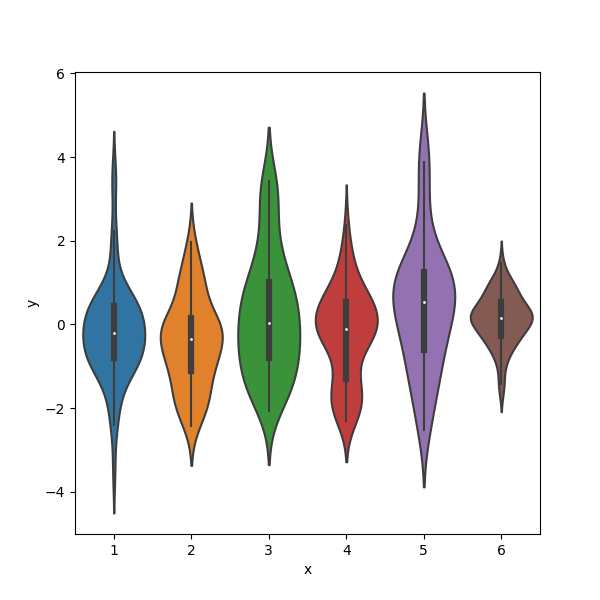

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

In [26]:
util.plot_distribs(X.t())

In [3]:
dataset2 = fig.quick_run('load-data', name='3dshapes', mode='full', labeled=True, shuffle=False, seed=seed)
len(dataset2)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > num_workers: 0 (by default)
|  > batch_size: 64 (by default)
|  > shuffle: False
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > _dataset_type --> dataset-name --> name: '3dshapes'
|  > _dataset_mod: [] (by default)
|  > default_mode --> mode: 'full'
|  > mode-aliases: {} (by default)
|  > seed: 10
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 10
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/3dshapes)
|  >  > mode: 'full'
|  >  > labeled: True
|  >  > label_type: 'class' (by default)
|  >  > din: (3, 64, 64) (by default)
|  >  > dout: 6 (by default)
|  >  > device: 'cuda' (by default)
|  >  > fid_ident: None (by 

480000

In [4]:
factors = dataset2.get_mechanism_names()
factor_sizes = dataset2.get_label_sizes()
factors, factor_sizes

(['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation'],
 [10, 10, 10, 8, 4, 15])

In [5]:
sampler = InterventionSamplerBase(dataset2)
# interventions = sample_full_interventions(sampler, num_groups=20, pbar=tqdm)

<IPython.core.display.Javascript object>


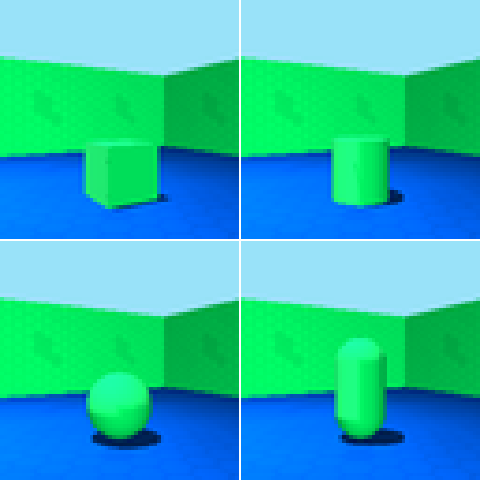

In [9]:
intervention_dim = 4
intervention_imgs = sampler.full_intervention(intervention_dim)
imgs = intervention_imgs
util.plot_imgs(imgs);

In [72]:
root = Path(r'C:\Users\anwan\Documents\workspace\exts')
root = Path(r'C:\Users\anwan\Documents\workspace\extrap')
# root = Path(r'C:\Users\anwan\Documents\workspace\trained_nets')
run_names = os.listdir(str(root))
# run_names = [r for r in run_names if '210509' in r or '210510' in r or '210511' in r]
run_names = [r for r in run_names if '_ohu_' in r or '_sh-' in r or '_sh_' in r]
len(run_names)

68

In [73]:
print(tabulate(enumerate(run_names)))

--  -------------------------------------------
 0  3ds_ae_e-c12_d-c12_ohu_210517-234751
 1  3ds_ae_e-c12_d-c12_sh_210517-232435
 2  3ds_ae_e-c12_d-s12_ohu_210517-234849
 3  3ds_ae_e-c12_d-s12_sh-nosplit_210517-233333
 4  3ds_ae_e-c12_d-s12_sh_210517-233136
 5  3ds_ae_e-c12_d-s6_ohu_210517-234851
 6  3ds_ae_e-c12_d-s6_sh_210517-233133
 7  3ds_model_sh-ae-both_210519-010459
 8  3ds_model_sh-ae-both_210519-010500
 9  3ds_model_sh-ae-both_210519-010500_2
10  3ds_model_sh-ae-both_210519-010501
11  3ds_model_sh-ae-dec_210519-010459
12  3ds_model_sh-ae-dec_210519-010500
13  3ds_model_sh-ae-dec_210519-010500_2
14  3ds_model_sh-ae-dec_210519-110544
15  3ds_model_sh-ae-enc_210519-010459
16  3ds_model_sh-ae-enc_210519-010459_2
17  3ds_model_sh-ae-enc_210519-010500
18  3ds_model_sh-ae-enc_210519-010500_2
19  3ds_model_sh-l12-both_210519-010500
20  3ds_model_sh-l12-both_210519-010500_2
21  3ds_model_sh-l12-dec_210519-010459
22  3ds_model_sh-l12-dec_210519-010500
23  3ds_model_sh-l12-enc_210519-010

In [74]:
# run_name = run_names[8]
# run_name = run_names[9]

# run_name

In [75]:
fig.get_config().silence()

In [91]:
runs = [fig.quick_run('load-run', path=v, root=str(root), **{'override.legacy':True, 'override.root': str(root)}) for v in run_names]
len(runs)

ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: 

68

In [92]:
runs = [r for r in runs if '_sh_' in r.get_config().pull('load-model', '_sh_')]
runs = [r for r in runs if 'sh' in r.get_config().pull('info')['extra']]
len(runs)

33

In [93]:
rows = [[r.name, r.get_config().pull('load-model', None)] for r in runs]
print(tabulate(rows))

-------------------------------------------  --------------------------------------
3ds_ae_e-c12_d-c12_sh_210517-232435
3ds_ae_e-c12_d-s12_sh-nosplit_210517-233333
3ds_ae_e-c12_d-s12_sh_210517-233136
3ds_ae_e-c12_d-s6_sh_210517-233133
3ds_model_sh-ae-both_210519-010459           3ds_ae_e-c12_d-s6_sh_210517-233133
3ds_model_sh-ae-both_210519-010500           3ds_ae_e-c12_d-c12_sh_210517-232435
3ds_model_sh-ae-dec_210519-010459            3ds_ae_e-c12_d-s6_sh_210517-233133
3ds_model_sh-ae-dec_210519-110544            3ds_ae_e-c12_d-c12_sh_210517-232435
3ds_model_sh-ae-enc_210519-010459            3ds_ae_e-c12_d-c12_sh_210517-232435
3ds_model_sh-ae-enc_210519-010500            3ds_ae_e-c12_d-s6_sh_210517-233133
3ds_model_sh-l12-both_210519-010500          3ds_vae1_e-l12_d-l12_sh_210517-234751
3ds_model_sh-l12-dec_210519-010459           3ds_vae1_e-l12_d-l12_sh_210517-234751
3ds_model_sh-l12-enc_210519-010500           3ds_vae1_e-l12_d-l12_sh_210517-234751
3ds_model_sh-s12-both_210519-0105

In [131]:
run = runs[1]
run

INLINE_TIMED_SAE_RUN:3ds_ae_e-c12_d-s12_sh-nosplit_210517-233333

In [132]:
info = run.get_config().pull('info')
info

{'arch_type': 'strc',
 'dataset_type': '3ds',
 'dec_type': 's12',
 'enc_type': 'c12',
 'extra': 'sh-nosplit',
 'model_type': 'ae',
 'nosplit': True,
 'size': 64}

In [96]:
# viz(run.get_config())

In [97]:
# print('\n'.join(sorted([r.name for r in runs])))

In [98]:
# A = run.get_config()

In [99]:
# viz(A.pull('dataset', raw=True))

In [100]:
cut = 'xas'
cut = 'xa'
cut = 'sh'
cut = 'ohu'

In [133]:
srcs = {}
bad = None
byname = {r.name:r for r in runs}
for run in runs:
    if f'{cut}-' in run.name or f'{cut}_' in run.name:
        A = run.get_config()
        info = A.pull('info')
        if 'model_type' in info:
            if 'wae' == info['model_type']:
                run.code = 'WAE'
            elif 'l' in info['dec_type']:
                run.code = 'LVAE' + info['dec_type'][1:]
            elif 'nosplit' in info:
                run.code = 'AdaAE' + info['dec_type'][1:]
            elif 's' in info['dec_type']:
                run.code = ('SAE' if A.pull('model.decoder.split-style',True) else 'AdaAE') + info['dec_type'][1:]
            elif info['model_type'] == 'vae' and 'l' not in info['dec_type']:
                run.code = 'VAE{}'.format(A.pull('reg-wt'))
            elif info['model_type'] == 'ae' and info['dec_type'] == 'c12':
                run.code = 'AE'
#             elif info['model_type'] == 'vae':
#                 run.code = 'VAE'
#                 pass
            else:
                bad = run
                break
            run.updates = {'self':run}
            srcs[run.code] = run
for run in runs:
    if f'{cut}-' in run.name or f'{cut}_' in run.name:
        A = run.get_config()
        info = A.pull('info')
        if 'model_type' not in info:
            src = byname[A.pull('load-model')]
            src.updates[info['extra'].split('-')[-1]] = run
bad

In [163]:
print(tabulate(byname.items()))

-------------------------------------------  -------------------------------------------
3ds_ae_e-c12_d-c12_sh_210517-232435          3ds_ae_e-c12_d-c12_sh_210517-232435
3ds_ae_e-c12_d-s12_sh-nosplit_210517-233333  3ds_ae_e-c12_d-s12_sh-nosplit_210517-233333
3ds_ae_e-c12_d-s12_sh_210517-233136          3ds_ae_e-c12_d-s12_sh_210517-233136
3ds_ae_e-c12_d-s6_sh_210517-233133           3ds_ae_e-c12_d-s6_sh_210517-233133
3ds_model_sh-ae-both_210519-010459           3ds_model_sh-ae-both_210519-010459
3ds_model_sh-ae-both_210519-010500           3ds_model_sh-ae-both_210519-010500
3ds_model_sh-ae-dec_210519-010459            3ds_model_sh-ae-dec_210519-010459
3ds_model_sh-ae-dec_210519-110544            3ds_model_sh-ae-dec_210519-110544
3ds_model_sh-ae-enc_210519-010459            3ds_model_sh-ae-enc_210519-010459
3ds_model_sh-ae-enc_210519-010500            3ds_model_sh-ae-enc_210519-010500
3ds_model_sh-l12-both_210519-010500          3ds_model_sh-l12-both_210519-010500
3ds_model_sh-l12-dec_21

In [134]:
srcs

{'AE': INLINE_TIMED_SAE_RUN:3ds_ae_e-c12_d-c12_sh_210517-232435,
 'AdaAE12': INLINE_TIMED_SAE_RUN:3ds_ae_e-c12_d-s12_sh-nosplit_210517-233333,
 'SAE12': INLINE_TIMED_SAE_RUN:3ds_ae_e-c12_d-s12_sh_210517-233136,
 'SAE6': INLINE_TIMED_SAE_RUN:3ds_ae_e-c12_d-s6_sh_210517-233133,
 'VAE1': INLINE_TIMED_SAE_RUN:3ds_vae1_e-c12_d-c12_sh_210517-232435,
 'LVAE12': INLINE_TIMED_SAE_RUN:3ds_vae1_e-l12_d-l12_sh_210517-234751,
 'VAE2': INLINE_TIMED_SAE_RUN:3ds_vae2_e-c12_d-c12_sh_210517-232440,
 'VAE4': INLINE_TIMED_SAE_RUN:3ds_vae4_e-c12_d-c12_sh_210517-232646,
 'WAE': INLINE_TIMED_SAE_RUN:3ds_wae10_e-c12_d-c12_sh_210517-232435}

In [135]:
mcat = 'AdaAE12'

In [136]:
docket = ['SAE12', 'SAE6', 'LVAE12', 'VAE1', 'VAE4', 'AdaAE12', 'AE', 'WAE']
skews = None

In [159]:
base = srcs['AdaAE12']

In [160]:
base.updates

{'self': INLINE_TIMED_SAE_RUN:3ds_ae_e-c12_d-s12_sh-nosplit_210517-233333}

In [106]:
if dataset is None:
    dataset = base.get_dataset()
    dataset.switch_to('extra')

In [107]:
loader = dataset.get_loader(batch_size=128)

In [150]:
if docket is None:
    docket = list(srcs)
print(f'On the docket: {docket}')
losses = {doc: {} for doc in docket}
recs = {doc: {} for doc in docket}
starter = None
for i, (X, *other) in tqdm(enumerate(loader), total=len(loader)):
    if i == 25:
        break
    for basename in docket:
        base = srcs.get(basename, None)
        if base is None:
            print(f'{basename} not found')
            continue
        
        lss = losses[basename]
        rcs = recs[basename]
        sks = list(base.updates) if skews is None else skews
        
        for sk in sks:
            if sk not in lss:
                lss[sk] = []
            r = base.updates.get(sk, None)
            if r is None:
                print(f'{basename}-{sk} not found')
                continue
            model = r.get_model()
            model.to(device)
            with torch.no_grad():
                R, Q = model(X.to(device), ret_q=True)
                R = R.cpu()
                if isinstance(Q, distrib.Distribution):
                    Q = Q.mean
                Q = Q.cpu()
                X = X.cpu()
                L = F.mse_loss(X, R, reduction='none').reshape(X.size(0),-1).mean(-1)
            lss[sk].append(L.cpu())
            if sk not in rcs:
                rcs[sk] = R.cpu()
                starter = X
            model.cpu()
for d in losses.values():
    for k, ls in d.items():
        d[k] = torch.cat(ls)

On the docket: ['SAE12', 'SAE6', 'LVAE12', 'VAE1', 'VAE4', 'AdaAE12', 'AE', 'WAE']


  0%|          | 0/750 [00:00<?, ?it/s]

In [151]:
{k:len(v) for k,v in losses.items()}

{'SAE12': 4,
 'SAE6': 4,
 'LVAE12': 4,
 'VAE1': 4,
 'VAE4': 4,
 'AdaAE12': 1,
 'AE': 4,
 'WAE': 4}

In [152]:
mkeys = list(base.updates)
mkeys = ['self', 'enc', 'dec', 'both']
mkeys

['self', 'enc', 'dec', 'both']

In [153]:
stat_fns = {
    'mean': lambda x: x.mean(-1),#.tolist(),
    '90%': lambda x: x.quantile(0.9, dim=1),#.tolist(),
}
statorder = ['mean', '90%']
statorder = ['mean']

In [154]:
stats = {}
for k, ls in losses.items():
    L = torch.stack([ls[key] for key in mkeys if key in ls])
    stats[k] = torch.stack([stat_fns[name](L) for name in statorder])
stats.keys()

dict_keys(['SAE12', 'SAE6', 'LVAE12', 'VAE1', 'VAE4', 'AdaAE12', 'AE', 'WAE'])

In [155]:
rows = []

for doc in docket:
    
    row = [doc]
    
    sts = stats[doc]
    
    row.extend([f'{x*1000:.2f}' for x in sts.t().reshape(-1).tolist()])
    
    rows.append(row)

In [156]:
from itertools import product

In [157]:
headers = ['Model', *[f'{k}-{s}' for k,s in product(mkeys, statorder)]]
headers

['Model', 'self-mean', 'enc-mean', 'dec-mean', 'both-mean']

In [168]:
print(tabulate(rows, headers=headers, tablefmt='latex_raw'))

\begin{tabular}{lrrrr}
\hline
 Model   &   self-mean &   enc-mean &   dec-mean &   both-mean \\
\hline
 SAE12   &       13.21 &       7.7  &       0.42 &        0.34 \\
 SAE6    &       13.35 &       7.99 &       0.52 &        0.36 \\
 LVAE12  &       18.37 &       7.69 &       1.55 &        0.62 \\
 VAE1    &       12.97 &       8.78 &       0.44 &        0.46 \\
 VAE4    &       15.49 &       8.31 &       1.35 &        0.52 \\
 AdaAE12 &       16.46 &            &            &             \\
 AE      &       11.81 &       7.31 &       0.38 &        0.35 \\
 WAE     &       11.68 &       7.87 &       0.37 &        0.35 \\
\hline
\end{tabular}


In [126]:
# print(tabulate(rows))

In [118]:
A = base.get_config()

In [119]:
base.updates

{'self': INLINE_TIMED_SAE_RUN:3ds_wae10_e-c12_d-c12_sh_210517-232435,
 'both': INLINE_TIMED_SAE_RUN:3ds_model_sh-wae10-both_210519-010459,
 'dec': INLINE_TIMED_SAE_RUN:3ds_model_sh-wae10-dec_210519-010459,
 'enc': INLINE_TIMED_SAE_RUN:3ds_model_sh-wae10-enc_210519-010500}

In [120]:
if dataset is None:
    dataset = base.get_dataset()
    len(dataset)

In [121]:
dataset.switch_to('extra')
len(dataset)

96075

In [122]:
loader = dataset.get_loader(batch_size=128)
len(loader)

750

In [123]:
for r in base.updates.values():
    model = r.get_model().cpu()

In [56]:
qs = {}
losses = {key: [] for key in mkeys}
for i, (X, *other) in tqdm(enumerate(loader), total=len(loader)):
    if i == 25:
        break
    for key, run in base.updates.items():
        model = run.get_model()
        with torch.no_grad():
            R, Q = model(X, ret_q=True)
            if isinstance(Q, distrib.Distribution):
                Q = Q.mean
            L = F.mse_loss(X, R, reduction='none').reshape(X.size(0),-1).mean(-1)
        losses[key].append(L)
        qs[key] = Q
#     break

  0%|          | 0/1199 [00:00<?, ?it/s]

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


In [57]:
for key, ls in losses.items():
    losses[key] = torch.cat(ls)
len(losses)

4

In [58]:
lats = torch.stack([qs[key] for key in mkeys])
lats.shape

torch.Size([4, 128, 12])

In [59]:
samples = torch.stack([losses[key] for key in mkeys])
samples.shape

torch.Size([4, 3200])

In [ ]:
samples.quantile(0.75, dim=1).tolist()

<IPython.core.display.Javascript object>


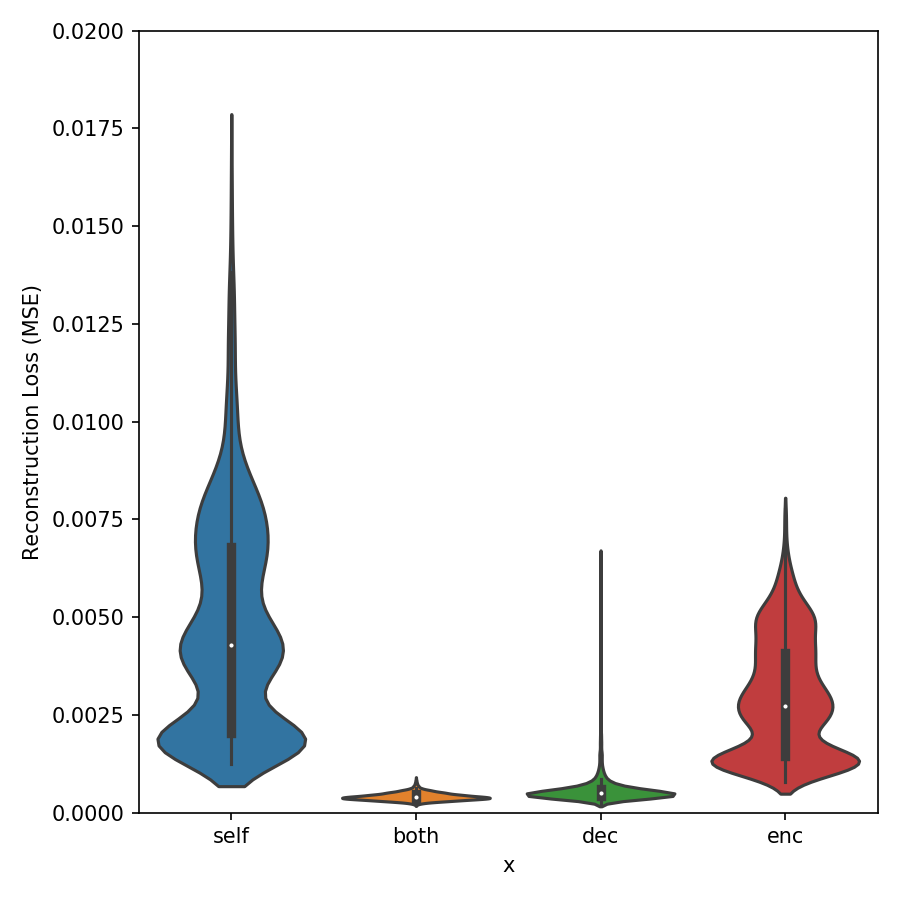

In [60]:
util.plot_distribs(samples, cut=True);
plt.ylim(0,0.02);
plt.xticks(range(len(mkeys)),mkeys)
plt.ylabel('Reconstruction Loss (MSE)')
plt.tight_layout();
# if figure_dir is not None:
#     util.save_figure(f'{setting}_{mcat}_losses',root=figure_dir)

In [61]:
samples.shape

torch.Size([4, 3200])

[0.006800592876970768,
 0.00046432059025391936,
 0.0006016419501975179,
 0.004090030677616596]

In [268]:
dataset = None
setting = 'xa'
raw = '''AE	3ds_ae_e-c12_d-c12_xa_210424-022637	3ds_model_xa-ae-enc_210426-160409	3ds_model_xa-ae-dec_210426-160409	3ds_model_xa-ae-both_210426-160408
WAE	3ds_wae10_e-c12_d-c12_xa_210424-022636	3ds_model_xa-wae-enc_210426-160410	3ds_model_xa-wae-dec_210426-160409	3ds_model_xa-wae-both_210426-160409
VAE	3ds_vae1_e-c12_d-c12_xa_210424-022638	3ds_model_xa-vae-enc_210426-160409	3ds_model_xa-vae-dec_210426-160409	3ds_model_xa-vae-both_210426-160409
2VAE	3ds_vae2_e-c12_d-c12_xa_210424-022637	3ds_model_xa-vae2-enc_210426-160410	3ds_model_xa-vae2-dec_210426-160408	3ds_model_xa-vae2-both_210426-160409
SAE12	3ds_ae_e-c12_d-s12_xa_210424-022637	3ds_model_xa-s12-enc_210426-160409	3ds_model_xa-s12-dec_210426-160409	'''.split('\n')
df = pd.DataFrame([r.split('\t') for r in raw], columns=['Model', 'Original', 'Encoder', 'Decoder', 'Both'])
df

,Model,Original,Encoder,Decoder,Both
0,AE,3ds_ae_e-c12_d-c12_xa_210424-022637,3ds_model_xa-ae-enc_210426-160409,3ds_model_xa-ae-dec_210426-160409,3ds_model_xa-ae-both_210426-160408
1,WAE,3ds_wae10_e-c12_d-c12_xa_210424-022636,3ds_model_xa-wae-enc_210426-160410,3ds_model_xa-wae-dec_210426-160409,3ds_model_xa-wae-both_210426-160409
2,VAE,3ds_vae1_e-c12_d-c12_xa_210424-022638,3ds_model_xa-vae-enc_210426-160409,3ds_model_xa-vae-dec_210426-160409,3ds_model_xa-vae-both_210426-160409
3,2VAE,3ds_vae2_e-c12_d-c12_xa_210424-022637,3ds_model_xa-vae2-enc_210426-160410,3ds_model_xa-vae2-dec_210426-160408,3ds_model_xa-vae2-both_210426-160409
4,SAE12,3ds_ae_e-c12_d-s12_xa_210424-022637,3ds_model_xa-s12-enc_210426-160409,3ds_model_xa-s12-dec_210426-160409,


In [117]:
dataset = None
setting = 'xas'
raw = '''AE	3ds_ae_e-c12_d-c12_xas_210424-022530	3ds_model_xas-ae-enc_210426-160409	3ds_model_xas-ae-dec_210426-160409	3ds_model_xas-ae-both_210426-160409
WAE	3ds_wae10_e-c12_d-c12_xas_210424-022529	3ds_model_xas-wae-enc_210426-160409	3ds_model_xas-wae-dec_210426-160409	3ds_model_xas-wae-both_210426-160407
VAE	3ds_vae1_e-c12_d-c12_xas_210424-022530	3ds_model_xas-vae-enc_210426-160409	3ds_model_xas-vae-dec_210426-160409	3ds_model_xas-vae-both_210426-160409
2VAE	3ds_vae2_e-c12_d-c12_xas_210424-022528	3ds_model_xas-vae2-enc_210426-160408	3ds_model_xas-vae2-dec_210426-160408	3ds_model_xas-vae2-both_210426-160409
SAE12	3ds_ae_e-c12_d-s12_xas_210424-022530	3ds_model_xas-s12-enc_210426-160407	3ds_model_xas-s12-dec_210426-160408	3ds_model_xas-s12-both_210426-160410'''.split('\n')
df = pd.DataFrame([r.split('\t') for r in raw], columns=['Model', 'Original', 'Encoder', 'Decoder', 'Both'])
df

,Model,Original,Encoder,Decoder,Both
0,AE,3ds_ae_e-c12_d-c12_xas_210424-022530,3ds_model_xas-ae-enc_210426-160409,3ds_model_xas-ae-dec_210426-160409,3ds_model_xas-ae-both_210426-160409
1,WAE,3ds_wae10_e-c12_d-c12_xas_210424-022529,3ds_model_xas-wae-enc_210426-160409,3ds_model_xas-wae-dec_210426-160409,3ds_model_xas-wae-both_210426-160407
2,VAE,3ds_vae1_e-c12_d-c12_xas_210424-022530,3ds_model_xas-vae-enc_210426-160409,3ds_model_xas-vae-dec_210426-160409,3ds_model_xas-vae-both_210426-160409
3,2VAE,3ds_vae2_e-c12_d-c12_xas_210424-022528,3ds_model_xas-vae2-enc_210426-160408,3ds_model_xas-vae2-dec_210426-160408,3ds_model_xas-vae2-both_210426-160409
4,SAE12,3ds_ae_e-c12_d-s12_xas_210424-022530,3ds_model_xas-s12-enc_210426-160407,3ds_model_xas-s12-dec_210426-160408,3ds_model_xas-s12-both_210426-160410


In [293]:
mcat = 'SAE12'
# mcat = 'VAE'
# mcat = 'AE'
mcat = '2VAE'
# mcat = 'WAE'

minfo = df[df['Model'] == mcat].to_dict()
minfo = {k: next(iter(v.values())) for k,v in minfo.items()}
minfo = {k: v for k,v in minfo.items() if v is not None and len(v)}
mname = minfo['Model']
del minfo['Model']
mname, minfo

('2VAE',
 {'Original': '3ds_vae2_e-c12_d-c12_xa_210424-022637',
  'Encoder': '3ds_model_xa-vae2-enc_210426-160410',
  'Decoder': '3ds_model_xa-vae2-dec_210426-160408',
  'Both': '3ds_model_xa-vae2-both_210426-160409'})

In [294]:
mkeys = list(minfo)
mkeys

['Original', 'Encoder', 'Decoder', 'Both']

In [295]:
runs = {k: fig.quick_run('load-run', path=v, root=str(root), **{'override.legacy':True, 'override.root': str(root)}) for k,v in minfo.items()}
len(runs)

| path: '3ds_vae2_e-c12_d-c12_xa_210424-022637'
| saveroot: None (by default)
| root: 'C:\\Users\\anwan\\Documents\\workspace\\exts'
| [Pushed] path: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_vae2_e-c12_d-c12_xa_210424-022637'
| run: [<class 'omnifig.config.ConfigDict'>]
| CREATING . (type=sae-run) (mod={'inline': 5, 'timed-run': 1})
|  > silent: None (by default)
|  > invisible: False (by default)
|  > use_config_root: True (by default)
|  > .path: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_vae2_e-c12_d-c12_xa_210424-022637'
|  > [Pushed] path: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_vae2_e-c12_d-c12_xa_210424-022637'
|  > ckpt-num: None (by default)
|  > best: False (by default)
|  > last: True (by default)
|  > [Pushed] dataset._load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_vae2_e-c12_d-c12_xa_210424-022637\\ckpt80000'
|  > [Pushed] model._load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_vae2_e-c12_d-c12_xa_210424-022637\\ckpt

4

In [296]:
run = runs['Original']

In [297]:
if dataset is None:
    dataset = run.get_dataset()
    len(dataset)

In [298]:
dataset.switch_to('extra')
len(dataset)

102271

In [299]:
# X, = dataset.get_batch(batch_size=64)
# X.shape

In [300]:
# util.plot_imgs(X);

In [301]:
# with torch.no_grad():
#     R, Q = model(X, ret_q=True)
#     if isinstance(Q, distrib.Distribution):
#         Q = Q.mean
# R.shape, Q.shape

In [302]:
# util.plot_imgs(R);

In [303]:
for run in runs.values():
    model = run.get_model()


| CREATING . (type=model)
|  > .legacy: True
|  > _load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_vae2_e-c12_d-c12_xa_210424-022637\\ckpt80000'
|  > load-model: None (by default)
|  > model._model_mod [dict with 2 item/s]
|  >  > (freezable): 8
|  >  > (hybrid): 1
|  > .seed: 0
|  > CREATING model (type=vae) (mod={'freezable': 8, 'hybrid': 1})
|  >  > freeze-encoder: False (by default)
|  >  > freeze-decoder: False (by default)
|  >  > viz-gen-hybrid: True (by default)
|  >  > viz-gen-prior: True (by default)
|  >  > [Pushed] reg: None
|  >  > CREATING encoder (type=multilayer) (mod={'normal': 1})
|  >  >  > change-dout: True (by default)
|  >  >  > _dout_key: 'latent-dim'
|  >  >  > ..latent-dim: 12
|  >  >  > _din --> ..din [list with 3 item/s]
|  >  >  >  > (0): 3
|  >  >  >  > (1): 64
|  >  >  >  > (2): 64
|  >  >  > _dout --> latent-dim: 24
|  >  >  > in_order: True (by default)
|  >  >  > first: [<class 'omnifig.config.ConfigDict'>]
|  >  >  > CREATING . (type=conv

Freezable_Hybrid_VAE(
  (encoder): Normal_MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=

|  >  >  > CREATING 10 (type=conv-layer)
|  >  >  >  > in-shape --> din: None
|  >  >  >  > ...channels: 64
|  >  >  >  > out-shape --> dout: (64, 32, 32)
|  >  >  >  > transpose: None (by default)
|  >  >  >  > down: None (by default)
|  >  >  >  > ..up: 1
|  >  >  >  > kernel_size --> kernel: (3, 3) (by default)
|  >  >  >  > padding: 1 (by default)
|  >  >  >  > dilation: (1, 1) (by default)
|  >  >  >  > stride: (1, 1) (by default)
|  >  >  >  > ...norm: 'group'
|  >  >  >  > ...nonlin: 'elu'
|  >  >  >  > conv_kwargs: {} (by default)
|  >  >  >  > residual: False (by default)
|  >  >  >  > force_res: False (by default)
|  >  >  >  > print_dims: False (by default)
|  >  >  >  > mode: 'train' (by default)
|  >  >  >  > ....device: 'cuda'
|  >  >  > CREATING 9 (type=conv-layer)
|  >  >  >  > in-shape --> din: None
|  >  >  >  > ...channels: 64
|  >  >  >  > out-shape --> dout: (64, 32, 32)
|  >  >  >  > transpose: None (by default)
|  >  >  >  > down: None (by default)
|  >  >  >  > 

|  >  >  >  > in-shape --> din: (64, 32, 32)
|  >  >  >  > ...channels: 64
|  >  >  >  > out-shape --> dout: None
|  >  >  >  > transpose: None (by default)
|  >  >  >  > ..down: 1
|  >  >  >  > up: None (by default)
|  >  >  >  > kernel_size --> kernel: (3, 3) (by default)
|  >  >  >  > padding: 1 (by default)
|  >  >  >  > dilation: (1, 1) (by default)
|  >  >  >  > stride: (1, 1) (by default)
|  >  >  >  > ...norm: 'group'
|  >  >  >  > ...nonlin: 'elu'
|  >  >  >  > conv_kwargs: {} (by default)
|  >  >  >  > residual: False (by default)
|  >  >  >  > force_res: False (by default)
|  >  >  >  > print_dims: False (by default)
|  >  >  >  > mode: 'train' (by default)
|  >  >  >  > ....device: 'cuda'
|  >  >  > CREATING 2 (type=conv-layer)
|  >  >  >  > in-shape --> din: (64, 32, 32)
|  >  >  >  > ...channels: 64
|  >  >  >  > out-shape --> dout: None
|  >  >  >  > transpose: None (by default)
|  >  >  >  > down: 2
|  >  >  >  > up: None (by default)
|  >  >  >  > ..pool: 'max'
|  >  >

Loaded parameters from C:\Users\anwan\Documents\workspace\exts\3ds_model_xa-vae2-dec_210426-160408\ckpt20000
| CREATING . (type=model)
|  > .legacy: True
|  > _load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_model_xa-vae2-both_210426-160409\\ckpt20000'
|  > .load-model: '3ds_vae2_e-c12_d-c12_xa_210424-022637'
|  > model._model_mod [dict with 2 item/s]
|  >  > (freezable): 8
|  >  > (hybrid): 1
|  > .seed: 0
|  > CREATING model (type=vae) (mod={'freezable': 8, 'hybrid': 1})
|  >  > freeze-encoder: False (by default)
|  >  > freeze-decoder: False (by default)
|  >  > viz-gen-hybrid: True (by default)
|  >  > viz-gen-prior: True (by default)
|  >  > [Pushed] reg: None
|  >  > CREATING encoder (type=multilayer) (mod={'normal': 1})
|  >  >  > change-dout: True (by default)
|  >  >  > _dout_key: 'latent-dim'
|  >  >  > ..latent-dim: 12
|  >  >  > _din --> ..din [list with 3 item/s]
|  >  >  >  > (0): 3
|  >  >  >  > (1): 64
|  >  >  >  > (2): 64
|  >  >  > _dout --> latent-dim:

Loaded parameters from C:\Users\anwan\Documents\workspace\exts\3ds_model_xa-vae2-both_210426-160409\ckpt20000


In [304]:
# imgs = sampler.full_intervention(intervention_dim)
# imgs.shape

In [305]:
# recs = {}
# for key, run in runs.items():
#     model = run.get_model()
#     with torch.no_grad():
#         rec = model(imgs.to(device))
#         rec = rec.permute(1,2,0,3).reshape(3, 64, -1).cpu() 
#         recs[key] = rec
# seqs = torch.stack([imgs.permute(1,2,0,3).reshape(3, 64, -1).cpu()] + [recs[k] for k in mkeys])
# util.plot_imgs(seqs, H=len(recs)+1);
# if figure_dir is not None:
#     util.save_figure(f'{setting}_{mcat}',root=figure_dir)

In [306]:
loader = dataset.get_loader(batch_size=128)
len(loader)

798

In [307]:
qs = {}
losses = {key: [] for key in mkeys}
for i, (X, *other) in tqdm(enumerate(loader), total=len(loader)):
    if i == 25:
        break
    for key, run in runs.items():
        model = run.get_model()
        with torch.no_grad():
            R, Q = model(X, ret_q=True)
            if isinstance(Q, distrib.Distribution):
                Q = Q.mean
            L = F.mse_loss(X, R, reduction='none').reshape(X.size(0),-1).mean(-1)
        losses[key].append(L)
        qs[key] = Q
    break

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/798 [00:00<?, ?it/s]

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


In [308]:
for key, ls in losses.items():
    losses[key] = torch.cat(ls)
len(losses)

4

In [309]:
lats = torch.stack([qs[key] for key in mkeys])
lats.shape

torch.Size([4, 128, 12])

In [310]:
samples = torch.stack([losses[key] for key in mkeys])
samples.shape

torch.Size([4, 128])

<IPython.core.display.Javascript object>


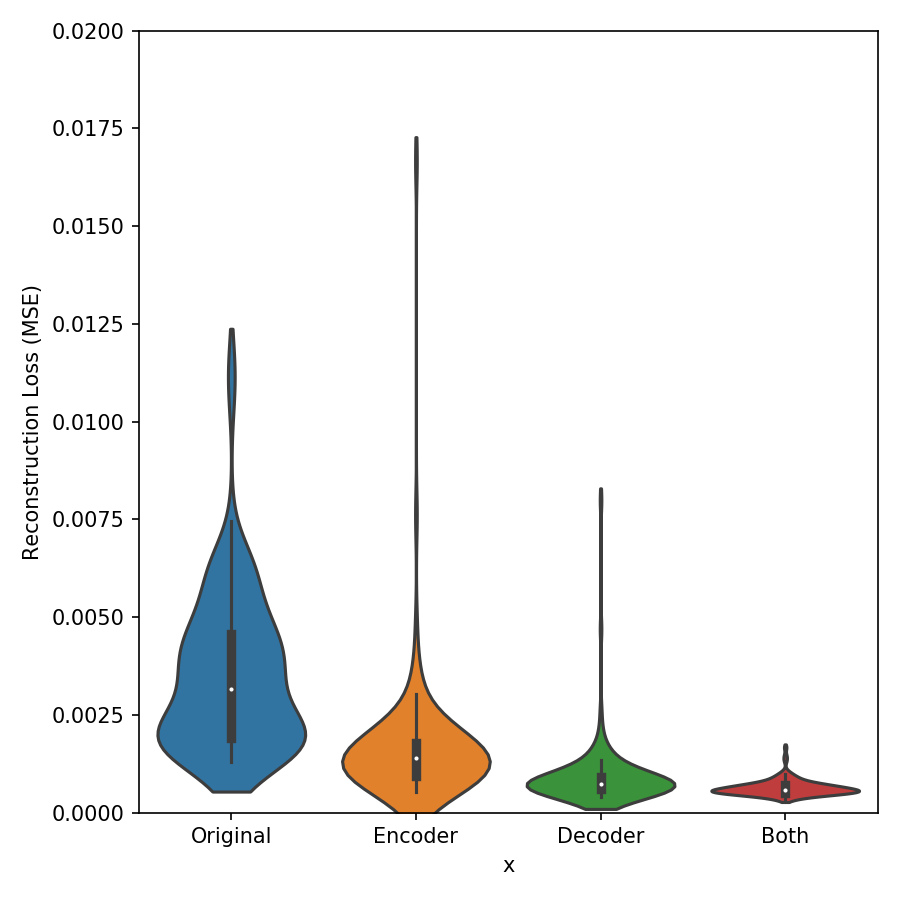

In [311]:
util.plot_distribs(samples, cut=True);
plt.ylim(0,0.02);
plt.xticks(range(len(mkeys)),mkeys)
plt.ylabel('Reconstruction Loss (MSE)')
plt.tight_layout();
# if figure_dir is not None:
#     util.save_figure(f'{setting}_{mcat}_losses',root=figure_dir)

In [312]:
model = runs['Original'].get_model()

In [313]:
fullQ = []
total = 10000
bs = 100
loader = dataset2.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    batch = next(loader)
    x = model._process_batch(batch).original
    with torch.no_grad():
        q = model.encode(x)
        if isinstance(q, distrib.Distribution):
            q = q.loc
        fullQ.append(q)
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ)
fullQ.shape

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 12])

In [314]:
scales = fullQ.std(0)
# scales = None

In [315]:
mats, lts = factor_reponses(model.encode, model.decode, interventions, pbar=tqdm, include_q=True, 
                       resp_kwargs=dict(scales=scales,force_different=True))
# W = mats.mean(-1).mean(1)

M = mats.min(1)[0].max(-1)[0]
# M = mats.mean(1).max(-1)[0]

mats.shape, len(lts), M.shape

  0%|          | 0/20 [00:00<?, ?it/s]

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

(torch.Size([6, 20, 12, 12]), 6, torch.Size([6, 12]))

<IPython.core.display.Javascript object>


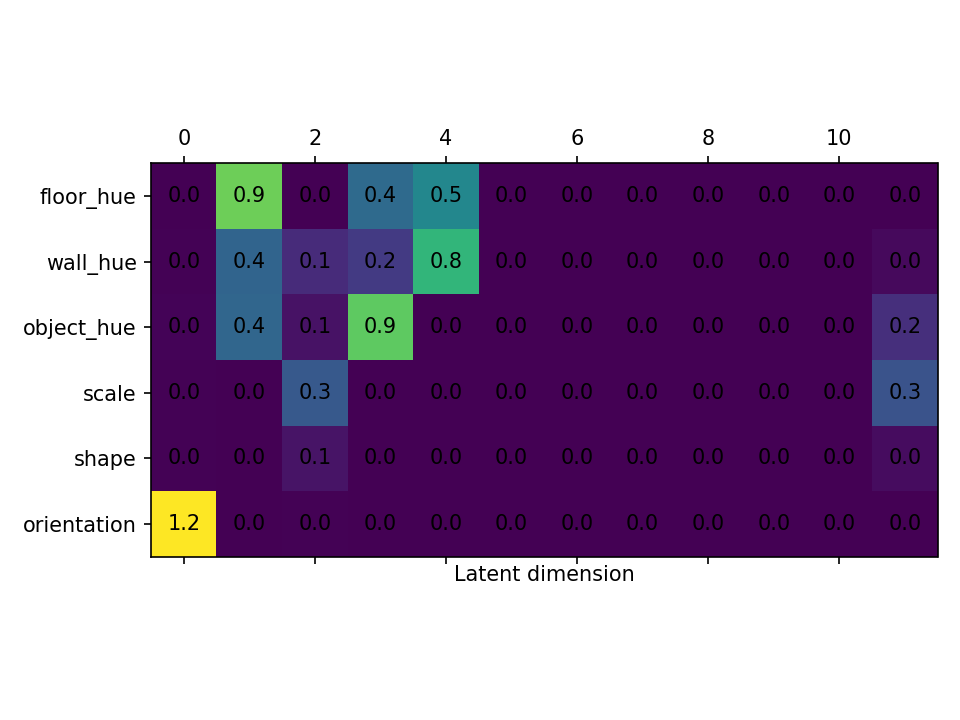

Figure xa_2VAE_factor-responses saved as {'png'}


In [316]:
util.plot_mat(M, val_fmt=1)
plt.yticks(range(len(factors)), factors)
plt.xlabel('Latent dimension')
plt.tight_layout()
# util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
util.save_figure(f'{setting}_{mname}_factor-responses', root=figure_dir)
pass # an intervention on which latent dimension responds the most given that the intervention can 
#      only change the given factor of variation

In [322]:
# xas
dim = 1 # SAE
dim = 9 # 2VAE
# dim = 6

# xa
dim = 2 # sae
dim = 0 # 2vae

In [323]:
# vals = lats[...,dim]
# util.plot_hists(vals.cpu().detach());

<IPython.core.display.Javascript object>


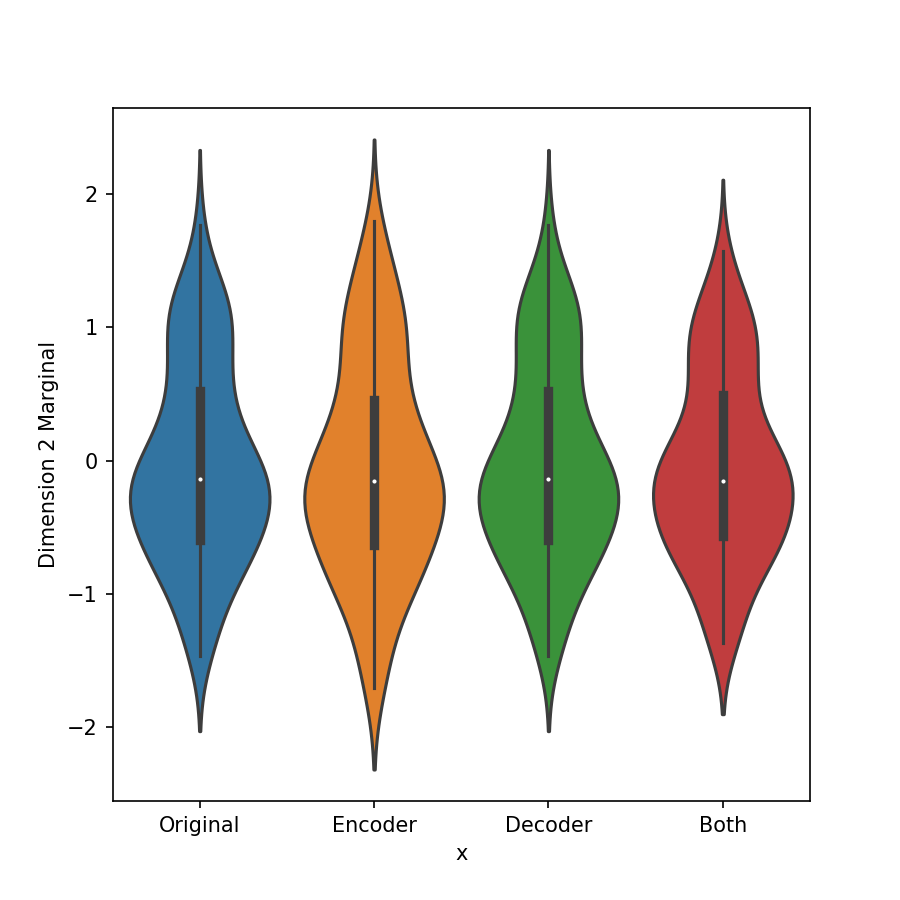

Text(0, 0.5, 'Dimension 2 Marginal')

In [324]:
vals = lats[...,dim]
util.plot_distribs(vals);
plt.xticks(range(len(mkeys)),mkeys)
plt.ylabel(f'Dimension {dim} Marginal')
util.save_figure(f'{setting}_{mname}_1d-latent-changes_dim{dim}', root=figure_dir)

<IPython.core.display.Javascript object>


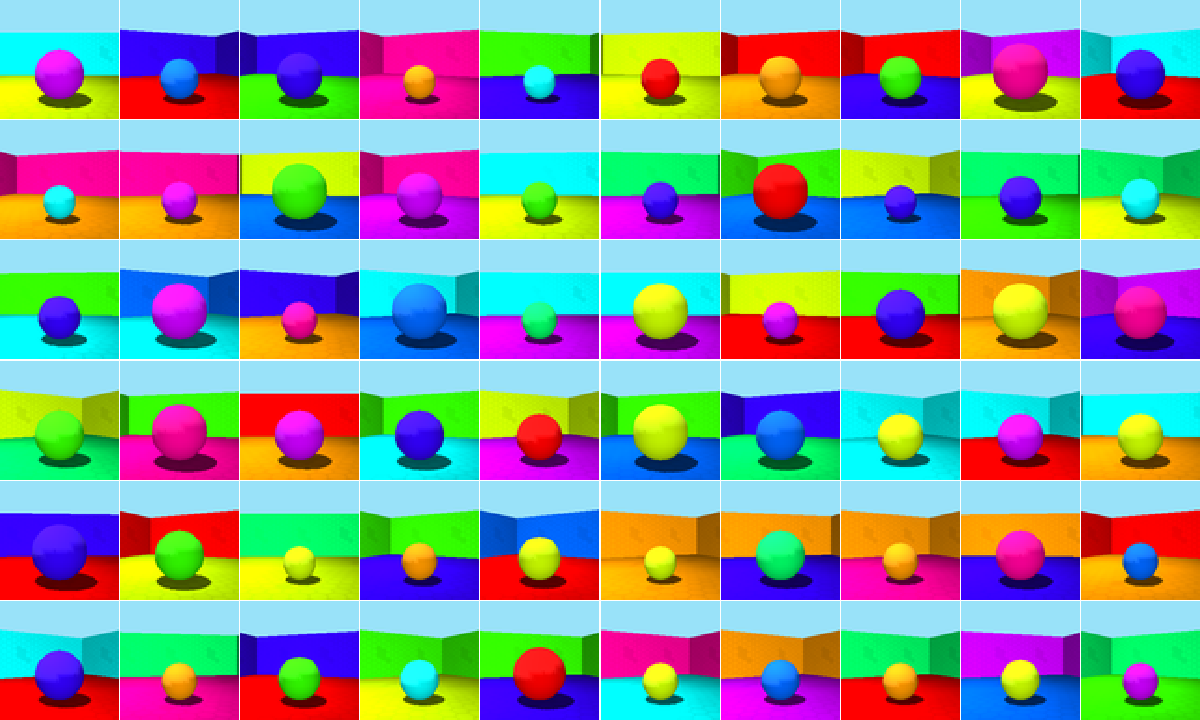

(<Figure size 800x480 with 60 Axes>, <numpy.flatiter at 0x26dd0473760>)

In [169]:
util.plot_imgs(starter[:60])

In [170]:
idx = 18 # xa
idx = 7 # xas

In [171]:
recs.keys()

dict_keys(['SAE12', 'SAE6', 'LVAE12', 'VAE1', 'VAE4', 'AdaAE12', 'AE', 'WAE'])

In [172]:
sel = ['SAE12', 'LVAE12', 'VAE4', 'AdaAE12']
sel = ['SAE12', 'LVAE12', 'VAE4', 'AE']

In [173]:
ims = torch.cat([torch.stack([starter[idx].cpu()] + [recs[s][k][idx] for k in mkeys]) for s in sel])
ims.shape

torch.Size([20, 3, 64, 64])

<IPython.core.display.Javascript object>


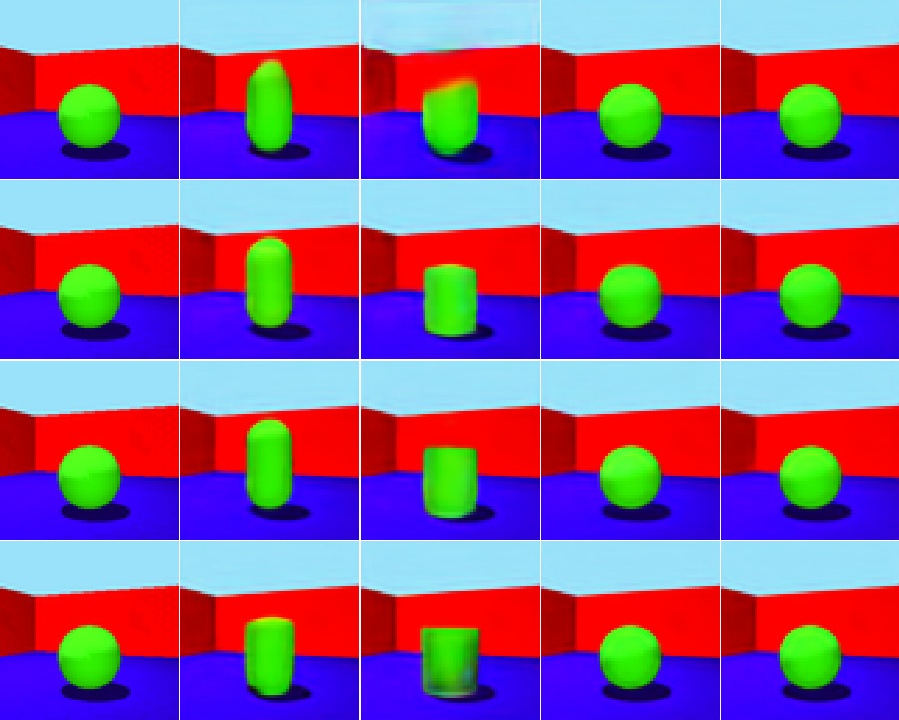

In [174]:
util.plot_imgs(ims, H=4);

In [175]:
H, W = len(sel),len(ims)//len(sel)
H,W

(4, 5)

<IPython.core.display.Javascript object>


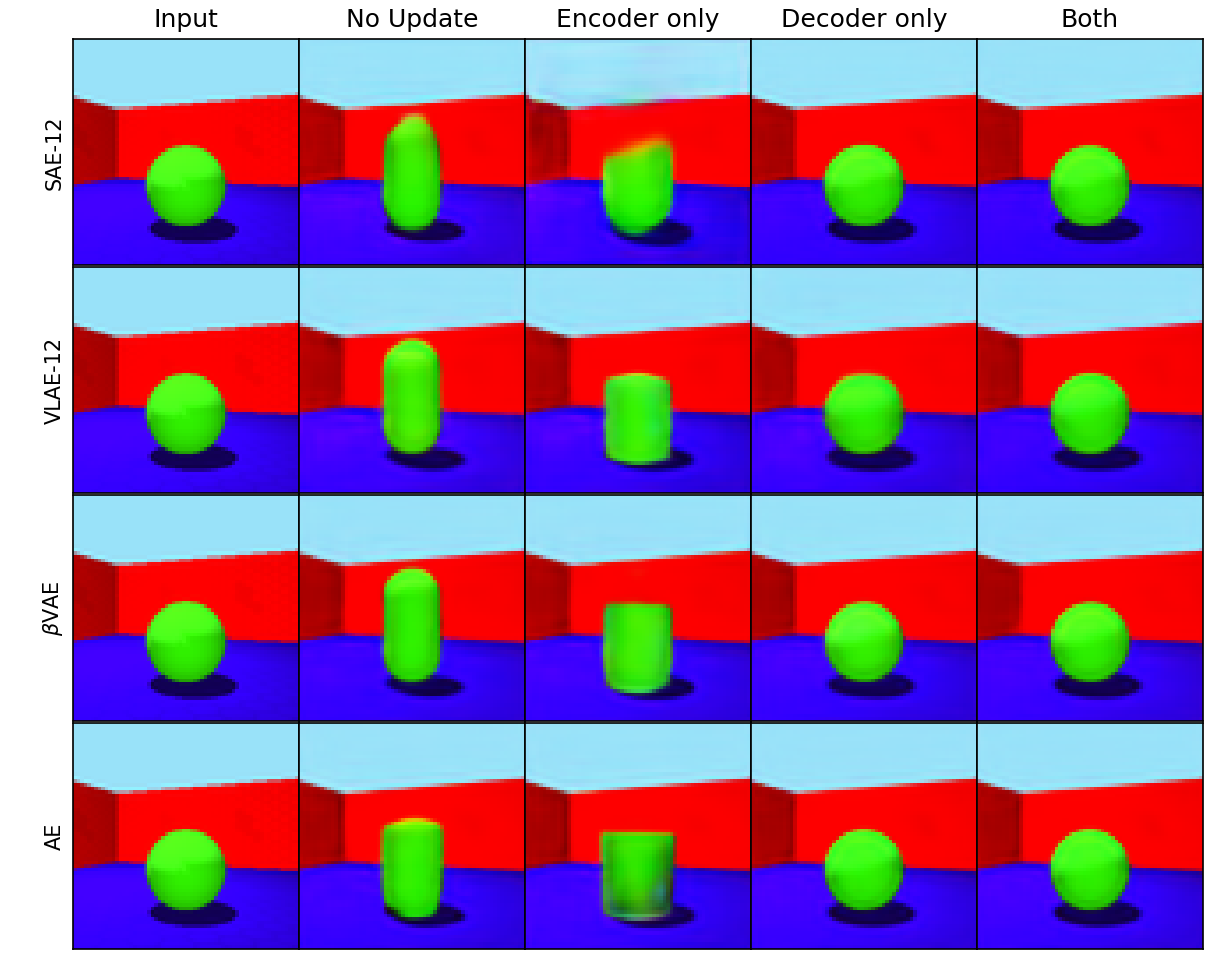

Figure sh_extrap_example saved as {'pdf', 'png'}


In [176]:
model_names = {'SAE12': 'SAE-12', 'LVAE12': 'VLAE-12', 'VAE1': 'VAE', 'VAE4': r'$\beta$VAE'}
colnames = ['Input', 'No Update', 'Encoder only', 'Decoder only', 'Both']

side = 1.6

fg, axs = plt.subplots(H, W, figsize=(side*W+0.1,side*H))

imgs = ims.cpu().view(H, W, 3, 64, 64).permute(0,1,3,4,2).cpu().detach().numpy()

for i, (rax, name, row) in enumerate(zip(axs, sel, imgs)):
    
    for ax, col, im in zip(rax, colnames, row):
        plt.sca(ax)
        if i == 0:
            plt.title(col)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(im)
    plt.sca(rax[0])
    plt.ylabel(model_names.get(name,name))
plt.subplots_adjust(hspace=0.0, wspace=0.0, bottom=0.01, top=0.96, left=0.06, right=0.99);

util.save_figure(f'{cut}_extrap_example', root=figure_dir, exts={'png', 'pdf'})